This project follows paper "[Federated Learning with Non-IID Data](https://arxiv.org/pdf/1806.00582.pdf)".

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 4, 3),
            nn.ReLU(),
            nn.MaxPool2d(3)
        )
        self.cnn2 = nn.Sequential(
            nn.Conv2d(4, 8, 3),
            nn.ReLU(),
            nn.MaxPool2d(3)
        )
        self.fc = nn.Linear(32, 10)

    def forward(self, img):
        output = self.cnn1(img)
        output = self.cnn2(output)
        output = self.fc(output.view(output.shape[0], -1))
        return F.softmax(output, dim=1)

def train(models, datas, optimizers):
    for i, (model, data, optimizer) in enumerate(zip(models, datas, optimizers)):
        model.train()
        n_batches = len(data)
        for batch in range(n_batches):
            X_train, y_train = data[batch][0], data[batch][1]
            y_pred = model(X_train)
            # print(X_train.shape, y_train.shape, y_pred.shape)
            loss = F.cross_entropy(y_pred, y_train)
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 0.1)
            optimizer.step()

def merge(models):
    n_model = len(models)
    state_dict = models[0].state_dict().copy()
    for key in state_dict:
        state_dict[key] = state_dict[key] / n_model
    for key in state_dict:
        for model in models[1:]:
            state_dict[key] = state_dict[key] + model.state_dict()[key] / n_model
    for model in models:
        model.load_state_dict(state_dict)


def fed_step(models, datas, optimizers):
    train(models, datas, optimizers)
    merge(models)


def to_batches(data, batch_size):
    batches = []
    n_batch = int(len(data) // batch_size)
    for i in range(n_batch):
        temp = data[i*batch_size:(i+1)*batch_size]
        X = [temp[j][0] for j in range(len(temp))]
        y = [temp[j][1] for j in range(len(temp))]
        X = torch.stack(X).cuda()
        y = torch.LongTensor(y).cuda()
        batches.append((X, y))
    return batches

def iid(dataset, batch_size):
    #cut to 10 iid datasets
    ind = np.arange(len(dataset))
    np.random.shuffle(ind)
    shuffled = [dataset[int(i)] for i in ind]
    data_size = int(len(dataset) // 10)
    datas = []
    for i in range(10):
        d = shuffled[i*data_size:(i+1)*data_size].copy()
        datas.append(to_batches(d, batch_size))
    return datas

def non_iid1(dataset, batch_size):
    datas = [[] for _ in range(10)]
    for data in dataset:
        datas[data[1]].append(data)
    for i in range(10):
        datas[i] = to_batches(datas[i], batch_size)
    return datas

def non_iid2(dataset, batch_size):
    datas = [[] for _ in range(10)]
    ind1 = np.arange(10)
    ind2 = np.arange(10)
    np.random.shuffle(ind1)
    np.random.shuffle(ind2)
    count = np.zeros(10)
    count_max = len(dataset) / (2 * 10)
    for data in dataset:
        label = data[1]
        if count[label] < count_max:
            datas[ind1[label]].append(data)
            count[label] += 1
        else:
            datas[ind2[label]].append(data)
    for i in range(10):
        datas[i] = to_batches(datas[i], batch_size)
    return datas

def sgd(dataset, batch_size):
    return [to_batches(dataset, batch_size)]

def non_iid1_share(dataset, batch_size, alpha=0.2):
    datas = [[] for _ in range(10)]
    for data in dataset:
        datas[data[1]].append(data)
    n_share = int(len(datas[0]) * alpha)
    shared = []
    new_datas = []
    for i in range(10):
        ind = np.random.choice(len(datas[i]), n_share)
        shared.extend([datas[i][j] for j in ind])
        new_data = [datas[i][j] for j in range(len(datas[i])) if j not in ind]
        new_datas.append(new_data)
    
    for i in range(10):
        new_datas[i].extend(shared)
        new_datas[i] = to_batches(new_datas[i], batch_size)
    return new_datas

def test(model, test_data):
    model.eval()
    X_test, y_test = test_data
    y_pred = model(X_test).detach()
    max_ = torch.argmax(y_pred, dim=1).long()
    # acc = confusion_matrix(y_test, y_pred)
    acc = torch.sum(max_ == y_test) / len(X_test)
    return acc

def get_weights(model):
    weights = {}
    for key in model.state_dict():
        if 'weight' not in key:
            continue
        weights[key] = model.state_dict()[key]
    return weights

# 1. Import data and manipulate data

In [ ]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize(0.5, 0.5),
                             ])
path = '/content/gdrive/MyDrive/courses/DetectionEst/final_proj/data'
mnist_trainset = datasets.MNIST(root=path, train=True, download=False, transform=transform)
mnist_testset = datasets.MNIST(root=path, train=False, download=False, transform=transform)

In [ ]:
data_sgd = sgd(list(mnist_trainset), 100)
datas_iid = iid(mnist_trainset, 100)
datas_noniid1 = non_iid1(mnist_trainset, 100)
datas_noniid2 = non_iid2(mnist_trainset, 100)
datas_shared_10 = non_iid1_share(mnist_trainset, 100, 0.1)
datas_shared_20 = non_iid1_share(mnist_trainset, 100, 0.2)
datas_shared_30 = non_iid1_share(mnist_trainset, 100, 0.3)

In [ ]:
X_test = [m[0] for m in mnist_testset]
y_test = [m[1] for m in mnist_testset]
X_test = torch.stack(X_test).cuda()
y_test = torch.FloatTensor(y_test).cuda()

# 2. Train IID, Non-IID 1, Non-IID 2 and joint training models

In [ ]:
model_sgd = [CNN().cuda()]
optimizer = [optim.Adam(model.parameters(), lr=0.001) for model in model_sgd]

accs_sgd = []
for comm_round in range(100):
    train(model_sgd, data_sgd, optimizer)
    acc = test(model_sgd[0], [X_test, y_test])
    accs_sgd.append(acc)
    if comm_round % 10 == 0:
        print("{} rounds, accuracy {}".format(comm_round, acc))

0 rounds, accuracy 0.7443000078201294
10 rounds, accuracy 0.8478999733924866
20 rounds, accuracy 0.9299999475479126
30 rounds, accuracy 0.9416999816894531
40 rounds, accuracy 0.9470999836921692
50 rounds, accuracy 0.9496999979019165
60 rounds, accuracy 0.9502999782562256
70 rounds, accuracy 0.9484999775886536
80 rounds, accuracy 0.9519999623298645
90 rounds, accuracy 0.9521999955177307


In [ ]:
models_iid = [CNN().cuda() for _ in range(10)]
optimizers_iid = [optim.Adam(model.parameters(), lr=0.001) for model in models_iid]

accs_iid = []
for comm_round in range(100):
    fed_step(models_iid, datas_iid, optimizers_iid)
    acc = test(models_iid[0], [X_test, y_test])
    accs_iid.append(acc)
    if comm_round % 10 == 0:
        print("{} rounds, accuracy {}".format(comm_round, acc))

0 rounds, accuracy 0.11219999939203262
10 rounds, accuracy 0.6643999814987183
20 rounds, accuracy 0.6825999617576599
30 rounds, accuracy 0.6887999773025513
40 rounds, accuracy 0.6923999786376953
50 rounds, accuracy 0.6935999989509583
60 rounds, accuracy 0.7720999717712402
70 rounds, accuracy 0.7789999842643738
80 rounds, accuracy 0.7809999585151672
90 rounds, accuracy 0.7831000089645386


In [ ]:
models_noniid1 = [CNN().cuda() for _ in range(10)]
optimizers_noniid1 = [optim.Adam(model.parameters(), lr=0.001) for model in models_noniid1]

accs_noniid1 = []
for comm_round in range(100):
    fed_step(models_noniid1, datas_noniid1, optimizers_noniid1)
    acc = test(models_noniid1[0], [X_test, y_test])
    accs_noniid1.append(acc)
    if comm_round % 10 == 0:
        print("{} rounds, accuracy {}".format(comm_round, acc))

0 rounds, accuracy 0.10089999437332153
10 rounds, accuracy 0.1290999948978424
20 rounds, accuracy 0.11309999972581863
30 rounds, accuracy 0.10759999603033066
40 rounds, accuracy 0.0997999981045723
50 rounds, accuracy 0.09989999979734421
60 rounds, accuracy 0.10529999434947968
70 rounds, accuracy 0.10319999605417252
80 rounds, accuracy 0.10319999605417252
90 rounds, accuracy 0.10610000044107437


In [ ]:
models_noniid2 = [CNN().cuda() for _ in range(10)]
optimizers_noniid2 = [optim.Adam(model.parameters(), lr=0.001) for model in models_noniid2]

accs_noniid2 = []
for comm_round in range(100):
    fed_step(models_noniid2, datas_noniid2, optimizers_noniid2)
    acc = test(models_noniid2[0], [X_test, y_test])
    accs_noniid2.append(acc)
    if comm_round % 10 == 0:
        print("{} rounds, accuracy {}".format(comm_round, acc))

0 rounds, accuracy 0.0989999994635582
10 rounds, accuracy 0.11299999803304672
20 rounds, accuracy 0.12370000034570694
30 rounds, accuracy 0.14649999141693115
40 rounds, accuracy 0.17170000076293945
50 rounds, accuracy 0.25279998779296875
60 rounds, accuracy 0.33719998598098755
70 rounds, accuracy 0.421999990940094
80 rounds, accuracy 0.505899965763092
90 rounds, accuracy 0.5403000116348267


# 3. Train models with data sharing

In [ ]:
models_shared = [CNN().cuda() for _ in range(10)]
optimizers_shared = [optim.Adam(model.parameters(), lr=0.001) for model in models_shared]

accs_shared = []
for comm_round in range(100):
    fed_step(models_shared, datas_shared, optimizers_shared)
    acc = test(models_shared[0], [X_test, y_test])
    accs_shared.append(acc)
    if comm_round % 10 == 0:
        print("{} rounds, accuracy {}".format(comm_round, acc))

0 rounds, accuracy 0.0973999947309494
10 rounds, accuracy 0.10279999673366547
20 rounds, accuracy 0.13939999043941498
30 rounds, accuracy 0.15680000185966492
40 rounds, accuracy 0.1850999891757965
50 rounds, accuracy 0.1972000002861023
60 rounds, accuracy 0.19749999046325684
70 rounds, accuracy 0.1875
80 rounds, accuracy 0.19249999523162842
90 rounds, accuracy 0.28139999508857727


In [ ]:
models_shared_20 = [CNN().cuda() for _ in range(10)]
optimizers_shared_20 = [optim.Adam(model.parameters(), lr=0.001) for model in models_shared_20]

accs_shared_20 = []
for comm_round in range(100):
    fed_step(models_shared_20, datas_shared_20, optimizers_shared_20)
    acc = test(models_shared_20[0], [X_test, y_test])
    accs_shared_20.append(acc)
    if comm_round % 10 == 0:
        print("{} rounds, accuracy {}".format(comm_round, acc))

0 rounds, accuracy 0.10279999673366547
10 rounds, accuracy 0.10279999673366547
20 rounds, accuracy 0.48319998383522034
30 rounds, accuracy 0.6912999749183655
40 rounds, accuracy 0.7594000101089478
50 rounds, accuracy 0.8229999542236328
60 rounds, accuracy 0.8575999736785889
70 rounds, accuracy 0.8748999834060669
80 rounds, accuracy 0.8866999745368958
90 rounds, accuracy 0.8925999999046326


In [ ]:
models_shared_30 = [CNN().cuda() for _ in range(10)]
optimizers_shared_30 = [optim.Adam(model.parameters(), lr=0.001) for model in models_shared_30]

accs_shared_30 = []
for comm_round in range(100):
    fed_step(models_shared_30, datas_shared_30, optimizers_shared_30)
    acc = test(models_shared_30[0], [X_test, y_test])
    accs_shared_30.append(acc)
    if comm_round % 10 == 0:
        print("{} rounds, accuracy {}".format(comm_round, acc))

0 rounds, accuracy 0.08919999748468399
10 rounds, accuracy 0.10279999673366547
20 rounds, accuracy 0.11349999904632568
30 rounds, accuracy 0.0982000008225441
40 rounds, accuracy 0.16459999978542328
50 rounds, accuracy 0.40539997816085815
60 rounds, accuracy 0.5956999659538269
70 rounds, accuracy 0.6640999913215637
80 rounds, accuracy 0.7135999798774719
90 rounds, accuracy 0.7441999912261963


# 4. Plot

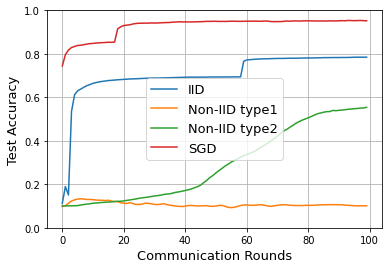

In [ ]:
plt.grid('on')
plt.plot(accs_iid)
plt.plot(accs_noniid1)
plt.plot(accs_noniid2)
plt.plot(accs_sgd)
plt.legend(['IID', 'Non-IID type1', 'Non-IID type2', 'SGD'], fontsize=13)
plt.xlabel('Communication Rounds', fontsize=13)
plt.ylabel('Test Accuracy', fontsize=13)
plt.ylim([0, 1])
plt.savefig('/content/gdrive/MyDrive/courses/DetectionEst/final_proj/result.pdf', dpi=300, quality=95)

In [ ]:
weights_sgd = get_weights(model_sgd[0])
weights_iid = get_weights(models_iid[0])
weights_noniid1 = get_weights(models_noniid1[0])
weights_noniid2 = get_weights(models_noniid2[0])
result_iid = []
result_noniid1 = []
result_noniid2 = []
for key in weights_iid.keys():
    result_iid.append(torch.linalg.norm(weights_iid[key] - weights_sgd[key]))
    result_noniid1.append(torch.linalg.norm(weights_noniid1[key] - weights_sgd[key]))
    result_noniid2.append(torch.linalg.norm(weights_noniid2[key] - weights_sgd[key]))

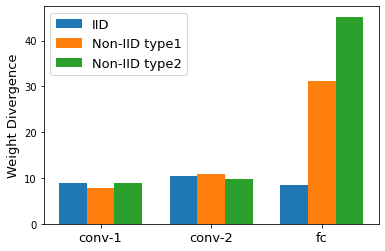

In [ ]:
labels = list(weights_sgd.keys())

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

# fig, ax = plt.subplots()
# rects1 = ax.bar(x - width/2, men_means, width, label='Men')
# rects2 = ax.bar(x + width/2, women_means, width, label='Women')
plt.bar(x-width, result_iid, width, label='IID')
plt.bar(x, result_noniid1, width, label='Non-IID type1')
plt.bar(x+width, result_noniid2, width, label='Non-IID type2')
plt.ylabel("Weight Divergence", fontsize=13)
plt.xticks(x, ["conv-1", "conv-2", "fc"], fontsize=13)
plt.legend(fontsize=13)

plt.savefig('/content/gdrive/MyDrive/courses/DetectionEst/final_proj/weight_divergence.pdf', dpi=300, quality=95)

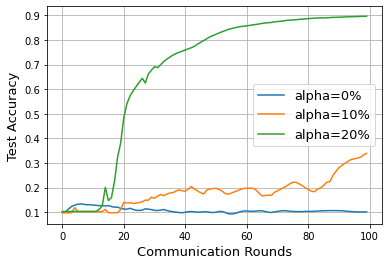

In [ ]:
plt.grid('on')
plt.plot(accs_noniid1)
plt.plot(accs_shared)
plt.plot(accs_shared_20)
plt.legend(['alpha=0%', 'alpha=10%', 'alpha=20%'], fontsize=13)
plt.xlabel('Communication Rounds', fontsize=13)
plt.ylabel('Test Accuracy', fontsize=13)
plt.savefig('/content/gdrive/MyDrive/courses/DetectionEst/final_proj/share.pdf', dpi=300, quality=95)